In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.preprocessing import FunctionTransformer

In [2]:
# Import data
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [3]:
# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    return x.drop(['review','review_processed','review_processed_stop'],axis=1)

def get_text_data(x):
    return x['review_processed']

transformer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [4]:
# Function to return metrics for test
def model_metrics(y_pred, y_pred_proba):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred, average='macro'))
    print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba))

    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

In [5]:
# Function to return metrics for train
def model_metrics_train(y_pred, y_pred_proba):
    print('Accuracy:', accuracy_score(y_train, y_pred))
    print('Precision:', precision_score(y_train, y_pred))
    print('Recall:', recall_score(y_train, y_pred))
    print('F1:', f1_score(y_train, y_pred, average='macro'))
    print('ROC_AUC:', roc_auc_score(y_train, y_pred_proba))

    print('\nConfusion Matrix:')
    print(confusion_matrix(y_train, y_pred))

    print('\nClassification Report:')
    print(classification_report(y_train, y_pred))

In [6]:
# Function to return a feature importance graph
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df = fi_df.sort_values(by=['feature_importance'], ascending=False).head(40)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Logistic Regression

In [7]:
# Load file
logreg = joblib.load('models/logreg.pkl')

In [8]:
# Model prediction
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_proba = logreg.predict_proba(X_test)[:, 1]

y_pred_logreg_train = logreg.predict(X_train)
y_pred_logreg_proba_train = logreg.predict_proba(X_train)[:, 1]

In [9]:
# Evaluation on test
model_metrics(y_pred_logreg, y_pred_logreg_proba)

Accuracy: 0.8604651162790697
Precision: 0.880354505169867
Recall: 0.9430379746835443
F1: 0.7963420051815193
ROC_AUC: 0.9095534373371748

Confusion Matrix:
[[ 251  162]
 [  72 1192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       413
           1       0.88      0.94      0.91      1264

    accuracy                           0.86      1677
   macro avg       0.83      0.78      0.80      1677
weighted avg       0.85      0.86      0.85      1677



In [10]:
# Evaluation on train
model_metrics_train(y_pred_logreg_train, y_pred_logreg_proba_train)

Accuracy: 0.8975939550606482
Precision: 0.907517309594461
Recall: 0.9630018367882446
F1: 0.8503322678148801
ROC_AUC: 0.9423923660615994

Confusion Matrix:
[[ 844  374]
 [ 141 3670]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      1218
           1       0.91      0.96      0.93      3811

    accuracy                           0.90      5029
   macro avg       0.88      0.83      0.85      5029
weighted avg       0.90      0.90      0.89      5029



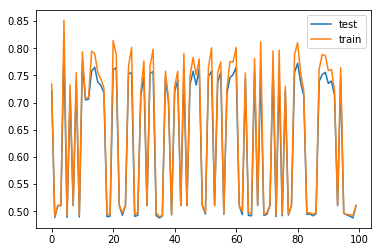

In [11]:
# Plot train and test F1 scores curves
test_scores_logreg = logreg.cv_results_['mean_test_F1']
train_scores_logreg = logreg.cv_results_['mean_train_F1']
plt.plot(test_scores_logreg, label='test')
plt.plot(train_scores_logreg, label='train')
plt.legend(loc='best')
plt.show()

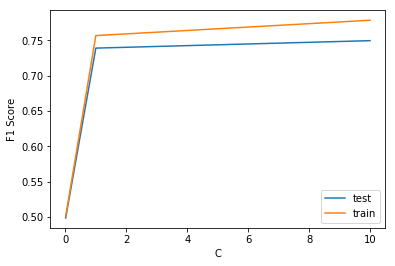

In [12]:
# Plot average train and test F1 scores for different values used in parameter C
logreg_results = pd.DataFrame(logreg.cv_results_['params'])
logreg_results['test score'] = logreg.cv_results_['mean_test_F1']
logreg_results['train score'] = logreg.cv_results_['mean_train_F1']
logreg_plot = logreg_results.groupby(['logreg__C']).agg('mean')
plt.plot(logreg_plot['test score'], label='test')
plt.plot(logreg_plot['train score'], label='train')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

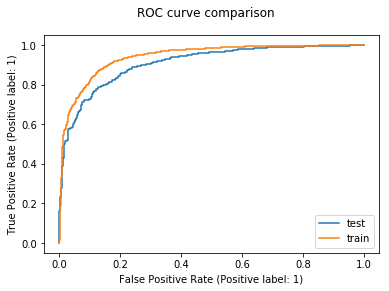

In [13]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_logreg = plot_roc_curve(logreg, X_test,y_test, ax=ax)
roc_train_logreg = plot_roc_curve(logreg,X_train,y_train, ax=ax)
roc_train_logreg.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

In [14]:
# Retrieve feature importance score for all features from Random Forest Classifier
logreg_feature_importance = logreg.best_estimator_[1].estimator_.feature_importances_

# Extract column names of all features
logreg_column_names = list(get_numeric_data(X_train).columns) + logreg.best_estimator_['features'].transformer_list[1][1][1].get_feature_names() 

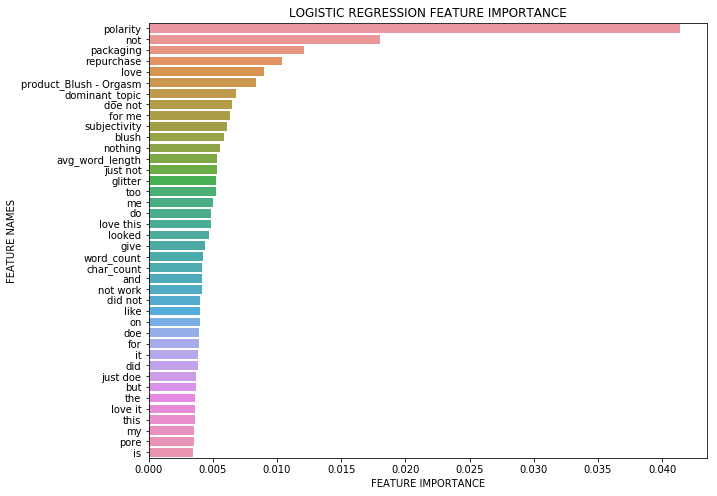

In [15]:
# Plot feature importance graph
plot_feature_importance(logreg_feature_importance, logreg_column_names, "LOGISTIC REGRESSION ")

# SVM

In [16]:
# Load file
svm = joblib.load('models/svm.pkl')

In [17]:
# Model prediction
y_pred_svm = svm.predict(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)[:, 1]

y_pred_svm_train = svm.predict(X_train)
y_pred_svm_proba_train = svm.predict_proba(X_train)[:, 1]

In [18]:
# Evaluation on test
model_metrics(y_pred_svm, y_pred_svm_proba)

Accuracy: 0.8425760286225402
Precision: 0.8654970760233918
Recall: 0.9367088607594937
F1: 0.7670225395515665
ROC_AUC: 0.8754712354798173

Confusion Matrix:
[[ 229  184]
 [  80 1184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.87      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.75      0.77      1677
weighted avg       0.83      0.84      0.83      1677



In [19]:
# Evaluation on train
model_metrics_train(y_pred_svm_train, y_pred_svm_proba_train)

Accuracy: 0.9996023066215948
Precision: 0.9997376016793492
Recall: 0.9997376016793492
F1: 0.9994582918084759
ROC_AUC: 0.9999997845662392

Confusion Matrix:
[[1217    1]
 [   1 3810]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1218
           1       1.00      1.00      1.00      3811

    accuracy                           1.00      5029
   macro avg       1.00      1.00      1.00      5029
weighted avg       1.00      1.00      1.00      5029



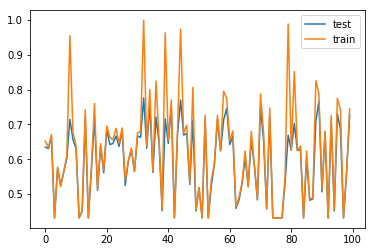

In [20]:
# Plot train and test F1 scores curves
test_scores_svm = svm.cv_results_['mean_test_F1']
train_scores_svm = svm.cv_results_['mean_train_F1'] 
plt.plot(test_scores_svm, label='test')
plt.plot(train_scores_svm, label='train')
plt.legend(loc='best')
plt.show()

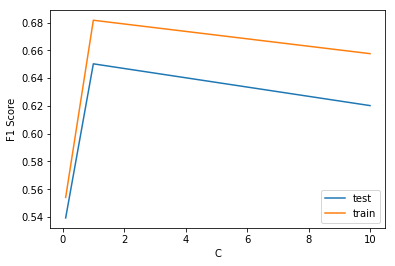

In [21]:
# Plot average train and test F1 scores for different values used in parameter C
svm_results = pd.DataFrame(svm.cv_results_['params'])
svm_results['test score'] = svm.cv_results_['mean_test_F1']
svm_results['train score'] = svm.cv_results_['mean_train_F1']
svm_plot = svm_results.groupby(['svm__C']).agg('mean')
plt.plot(svm_plot['test score'], label='test')
plt.plot(svm_plot['train score'], label='train')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

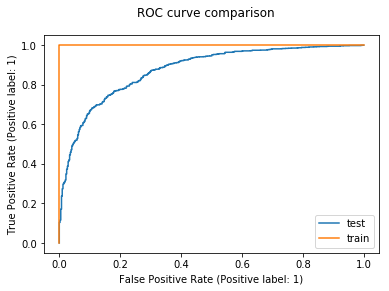

In [22]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_svm = plot_roc_curve(svm, X_test,y_test, ax=ax)
roc_train_svm = plot_roc_curve(svm, X_train,y_train, ax=ax)
roc_train_svm.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

In [23]:
# Retrieve feature importance score for all features from Random Forest Classifier
svm_feature_importance = svm.best_estimator_[1].estimator_.feature_importances_

# Extract column names of all features
svm_column_names = list(get_numeric_data(X_train).columns) + svm.best_estimator_['features'].transformer_list[1][1][1].get_feature_names() 

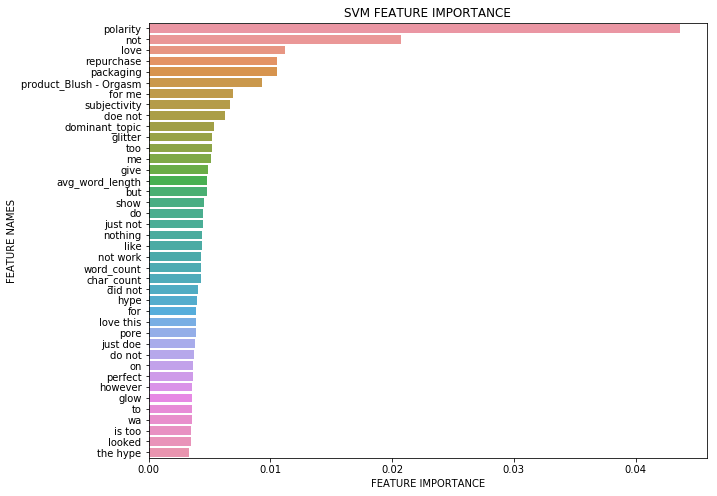

In [24]:
# Plot feature importance graph
plot_feature_importance(svm_feature_importance, svm_column_names, "SVM ")

# Naive Bayes

In [25]:
# Load file
nb = joblib.load('models/nb.pkl')

In [26]:
# Model prediction
y_pred_nb = nb.predict(X_test)
y_pred_nb_proba = nb.predict_proba(X_test)[:, 1]

y_pred_nb_train = nb.predict(X_train)
y_pred_nb_proba_train = nb.predict_proba(X_train)[:, 1]

In [27]:
# Evaluation on test
model_metrics(y_pred_nb, y_pred_nb_proba)

Accuracy: 0.8258795468097794
Precision: 0.824
Recall: 0.9778481012658228
F1: 0.6997203757757119
ROC_AUC: 0.8625927146228584

Confusion Matrix:
[[ 149  264]
 [  28 1236]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.36      0.51       413
           1       0.82      0.98      0.89      1264

    accuracy                           0.83      1677
   macro avg       0.83      0.67      0.70      1677
weighted avg       0.83      0.83      0.80      1677



In [28]:
# Evaluation on train
model_metrics_train(y_pred_nb_train, y_pred_nb_proba_train)

Accuracy: 0.8397295685026844
Precision: 0.8383247016437739
Recall: 0.9769089477827342
F1: 0.7280182823560609
ROC_AUC: 0.8643982353389785

Confusion Matrix:
[[ 500  718]
 [  88 3723]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.41      0.55      1218
           1       0.84      0.98      0.90      3811

    accuracy                           0.84      5029
   macro avg       0.84      0.69      0.73      5029
weighted avg       0.84      0.84      0.82      5029



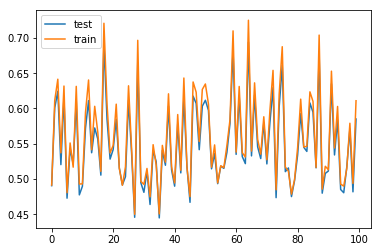

In [29]:
# Plot train and test F1 scores curves
test_scores_nb = nb.cv_results_['mean_test_F1']
train_scores_nb = nb.cv_results_['mean_train_F1'] 
plt.plot(test_scores_nb, label='test')
plt.plot(train_scores_nb, label='train')
plt.legend(loc='best')
plt.show()

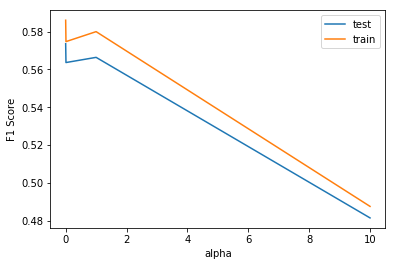

In [30]:
# Plot average train and test F1 scores for different values used in parameter alpha
nb_results = pd.DataFrame(nb.cv_results_['params'])
nb_results['test score'] = nb.cv_results_['mean_test_F1']
nb_results['train score'] = nb.cv_results_['mean_train_F1']
nb_plot = nb_results.groupby(['nb__alpha']).agg('mean')
plt.plot(nb_plot['test score'], label='test')
plt.plot(nb_plot['train score'], label='train')
plt.xlabel('alpha')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

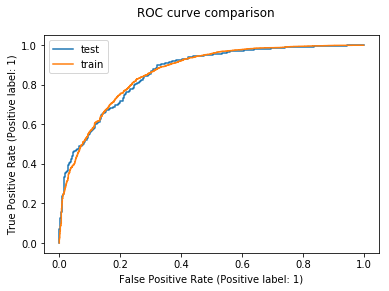

In [31]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_nb = plot_roc_curve(nb, X_test,y_test, ax=ax)
roc_train_nb = plot_roc_curve(nb, X_train,y_train, ax=ax)
roc_train_nb.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

In [32]:
# Retrieve feature importance score for all features from Random Forest Classifier
nb_feature_importance = nb.best_estimator_[1].estimator_.feature_importances_

# Extract column names of all features
nb_column_names = list(get_numeric_data(X_train).columns) + nb.best_estimator_['features'].transformer_list[1][1][1].get_feature_names() 

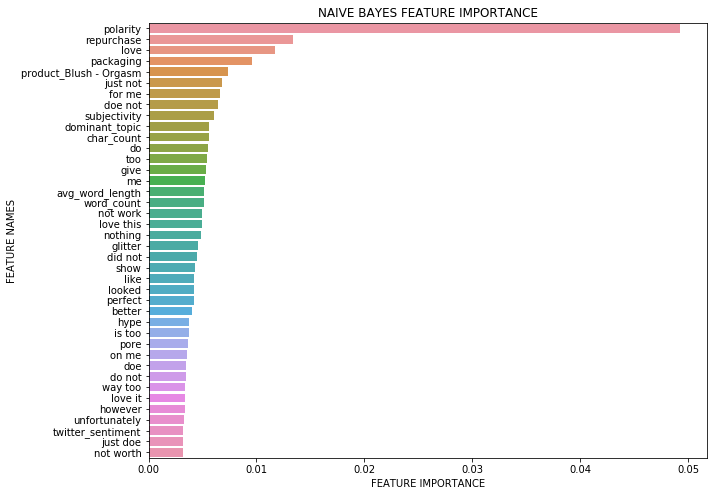

In [33]:
# Plot feature importance graph
plot_feature_importance(nb_feature_importance, nb_column_names, "NAIVE BAYES ")

# Stacking

In [34]:
# Predictions for train datasets and convert to dataframe
y_pred_logreg_train = pd.DataFrame(logreg.predict(X_train))
y_pred_svm_train = pd.DataFrame(svm.predict(X_train))
y_pred_nb_train = pd.DataFrame(nb.predict(X_train))

# Convert test datasets into dataframe
y_pred_logreg = pd.DataFrame(y_pred_logreg)
y_pred_svm = pd.DataFrame(y_pred_svm)
y_pred_nb = pd.DataFrame(y_pred_nb)

In [35]:
# Concatenate the predictions for both train and test datasets for all 3 models
df_train = pd.concat([y_pred_logreg_train, y_pred_svm_train, y_pred_nb_train],axis=1)
df_test = pd.concat([y_pred_logreg, y_pred_svm, y_pred_nb], axis=1)

In [36]:
# Load file
stack_model = joblib.load('models/stack_model.pkl')

In [37]:
# Model prediction
y_pred_stack = stack_model.predict(df_test)
y_pred_stack_proba = stack_model.predict_proba(df_test)[:, 1]

In [38]:
# Evaluation
model_metrics(y_pred_stack, y_pred_stack_proba)

Accuracy: 0.8425760286225402
Precision: 0.8654970760233918
Recall: 0.9367088607594937
F1: 0.7670225395515665
ROC_AUC: 0.7455941398228462

Confusion Matrix:
[[ 229  184]
 [  80 1184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       413
           1       0.87      0.94      0.90      1264

    accuracy                           0.84      1677
   macro avg       0.80      0.75      0.77      1677
weighted avg       0.83      0.84      0.83      1677



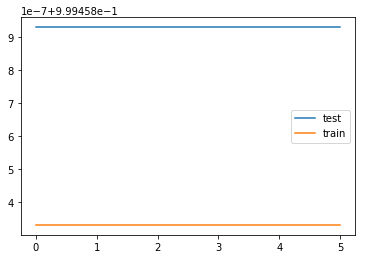

In [39]:
# Plot train and test F1 scores curves
test_scores_stack_model = stack_model.cv_results_['mean_test_F1']
train_scores_stack_model = stack_model.cv_results_['mean_train_F1'] 
plt.plot(test_scores_stack_model, label='test')
plt.plot(train_scores_stack_model, label='train')
plt.legend(loc='best')
plt.show()

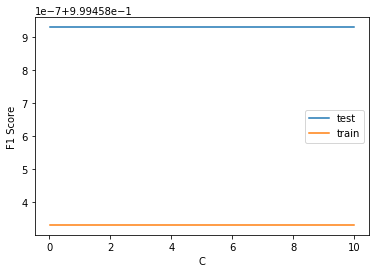

In [40]:
# Plot average train and test F1 scores for different values used in parameter C
stack_results = pd.DataFrame(stack_model.cv_results_['params'])
stack_results['test score'] = stack_model.cv_results_['mean_test_F1']
stack_results['train score'] = stack_model.cv_results_['mean_train_F1']
stack_plot = stack_results.groupby(['logreg__C']).agg('mean')
plt.plot(stack_plot['test score'], label='test')
plt.plot(stack_plot['train score'], label='train')
plt.xlabel('C')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

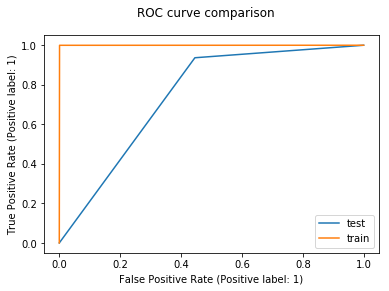

In [41]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_stack_model = plot_roc_curve(stack_model, df_test,y_test, ax=ax)
roc_train_stack_model = plot_roc_curve(stack_model, df_train,y_train, ax=ax)
roc_train_stack_model.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

# Bagging (Logistic Regression)

In [42]:
# Load file
logreg_bagging = joblib.load('models/logreg_bagging.pkl')
X_test_combined = pd.read_csv('data/X_test_vectorized_logreg.csv')
X_train_combined = pd.read_csv('data/X_train_vectorized_logreg.csv')

In [43]:
# Model prediction
y_pred_logreg_bagging = logreg_bagging.predict(X_test_combined)
y_pred_logreg_bagging_proba = logreg_bagging.predict_proba(X_test_combined)[:, 1]

In [44]:
# Evaluation
model_metrics(y_pred_logreg_bagging, y_pred_logreg_bagging_proba)

Accuracy: 0.874180083482409
Precision: 0.887988209285188
Recall: 0.9533227848101266
F1: 0.8158191290515842
ROC_AUC: 0.9264183038587672

Confusion Matrix:
[[ 261  152]
 [  59 1205]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       413
           1       0.89      0.95      0.92      1264

    accuracy                           0.87      1677
   macro avg       0.85      0.79      0.82      1677
weighted avg       0.87      0.87      0.87      1677



In [45]:
# Out of bag score
logreg_bagging.best_estimator_.oob_score_

0.862199244382581

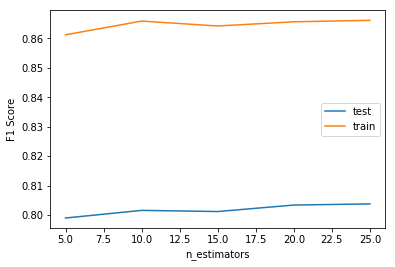

In [46]:
# Plot average train and test F1 scores for different values used in parameter n_estimators
logreg_bagging_results = pd.DataFrame(logreg_bagging.cv_results_['params'])
logreg_bagging_results['test score'] = logreg_bagging.cv_results_['mean_test_F1']
logreg_bagging_results['train score'] = logreg_bagging.cv_results_['mean_train_F1']
logreg_bagging_plot = logreg_bagging_results.groupby(['n_estimators']).agg('mean')
plt.plot(logreg_bagging_plot['test score'], label='test')
plt.plot(logreg_bagging_plot['train score'], label='train')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

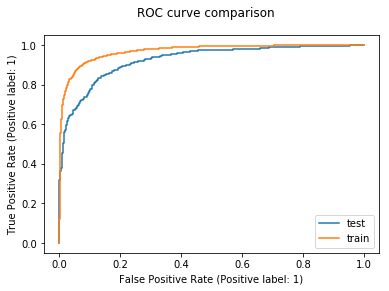

In [47]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_logreg_bagging = plot_roc_curve(logreg_bagging, X_test_combined,y_test, ax=ax)
roc_train_logreg_bagging = plot_roc_curve(logreg_bagging, X_train_combined,y_train, ax=ax)
roc_train_logreg_bagging.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()

# Bagging (Naive Bayes)

In [48]:
# Load file
nb_bagging = joblib.load('models/nb_bagging.pkl')
X_test_combined = pd.read_csv('data/X_test_vectorized_nb.csv')
X_train_combined = pd.read_csv('data/X_train_vectorized_nb.csv')

In [49]:
# Model prediction
y_pred_nb_bagging = nb_bagging.predict(X_test_combined)
y_pred_nb_bagging_proba = nb_bagging.predict_proba(X_test_combined)[:, 1]

In [50]:
# Evaluation
model_metrics(y_pred_nb_bagging, y_pred_nb_bagging_proba)

Accuracy: 0.8562909958258795
Precision: 0.8693140794223827
Recall: 0.9525316455696202
F1: 0.7835891504622379
ROC_AUC: 0.8877425138688815

Confusion Matrix:
[[ 232  181]
 [  60 1204]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.56      0.66       413
           1       0.87      0.95      0.91      1264

    accuracy                           0.86      1677
   macro avg       0.83      0.76      0.78      1677
weighted avg       0.85      0.86      0.85      1677



In [51]:
# Out of bag score
nb_bagging.best_estimator_.oob_score_

0.7995625372837543

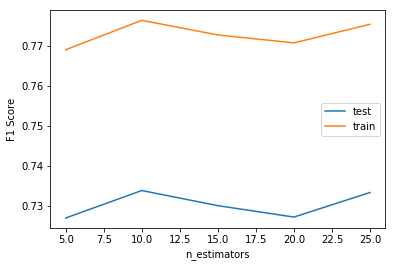

In [52]:
# Plot average train and test F1 scores for different values used in parameter n_estimators
nb_bagging_results = pd.DataFrame(nb_bagging.cv_results_['params'])
nb_bagging_results['test score'] = nb_bagging.cv_results_['mean_test_F1']
nb_bagging_results['train score'] = nb_bagging.cv_results_['mean_train_F1']
nb_bagging_plot = nb_bagging_results.groupby(['n_estimators']).agg('mean')
plt.plot(nb_bagging_plot['test score'], label='test')
plt.plot(nb_bagging_plot['train score'], label='train')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

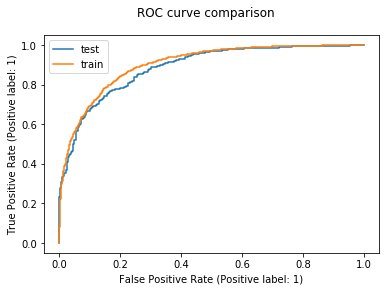

In [53]:
# Plot ROC curve for train and test dataset
ax = plt.gca()
roc_test_nb_bagging = plot_roc_curve(nb_bagging, X_test_combined,y_test, ax=ax)
roc_train_nb_bagging = plot_roc_curve(nb_bagging, X_train_combined,y_train, ax=ax)
roc_train_nb_bagging.figure_.suptitle("ROC curve comparison")
ax.legend(labels=['test','train'])
plt.show()